# Estudo de Caso de Tradução Automática - Dive into Deep Learning

## Passo 1: Download e Pré-processamento do Conjunto de Dados

In [ ]:
!pip install d2l

In [2]:

import os
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

# Função para baixar e extrair os dados do Projeto Tatoeba
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Carregar o dataset Inglês-Francês."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

# Carregar o texto bruto
raw_text = read_data_nmt()
print(raw_text[:75])


Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



## Passo 2: Pré-processamento dos Dados

In [3]:

# Função para pré-processar os dados
def preprocess_nmt(text):
    """Pré-processar o dataset Inglês-Francês."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)

# Aplicar pré-processamento
text = preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Passo 3: Tokenização e Obtenção do Vocabulário

In [4]:


# Função para tokenizar os dados
def tokenize_nmt(text, num_examples=None):
    """Tokenizar o dataset Inglês-Francês."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

# Tokenizar as frases
source, target = tokenize_nmt(text)
print(source[:6], target[:6])

# Construir o vocabulário
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
print(f'Tamanho do vocabulário da origem: {len(src_vocab)}')


[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!']] [['va', '!'], ['salut', '!'], ['cours', '!'], ['courez', '!'], ['qui', '?'], ['ça', 'alors', '!']]
Tamanho do vocabulário da origem: 10012


## Passo 4: Truncamento e Padding

In [5]:

# Função para truncar ou adicionar padding às sequências
def truncate_pad(line, num_steps, padding_token):
    """Truncar ou adicionar padding às sequências."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncar
    return line + [padding_token] * (num_steps - len(line))  # Padding

# Exemplo de truncamento e padding
print(truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>']))


[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]


## Passo 5: Construção de Arrays para o Modelo

In [6]:

# Função para transformar as sequências em lotes
def build_array_nmt(lines, vocab, num_steps):
    """Transformar as sequências em mini-batches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

# Função para carregar os dados
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Retorna o iterador e os vocabulários do dataset de tradução."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

# Carregar os dados
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('Tamanho válido para X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('Tamanho válido para Y:', Y_valid_len)
    break


X: tf.Tensor(
[[ 74 155   2   4   5   5   5   5]
 [182 106   2   4   5   5   5   5]], shape=(2, 8), dtype=int32)
Tamanho válido para X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[176  40   0   4   5   5   5   5]
 [  6   0   4   5   5   5   5   5]], shape=(2, 8), dtype=int32)
Tamanho válido para Y: tf.Tensor([4 3], shape=(2,), dtype=int32)


## Visualização dos Comprimentos das Frases

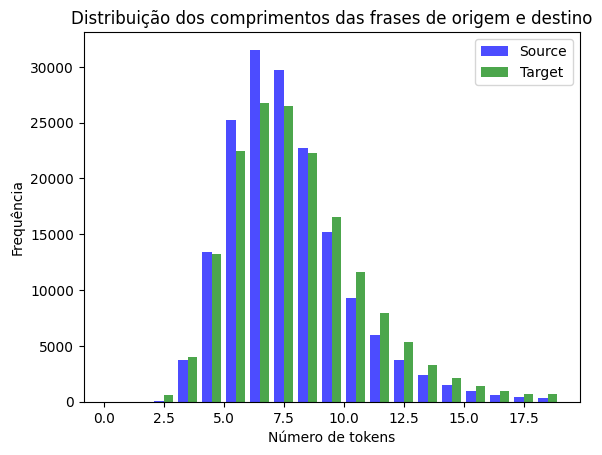

In [7]:

# Função para plotar a distribuição dos comprimentos das frases
def plot_sentence_length_distribution(source, target):
    """Plotar a distribuição dos comprimentos das frases de origem e destino."""
    source_lengths = [len(line) for line in source]
    target_lengths = [len(line) for line in target]

    plt.hist([source_lengths, target_lengths], bins=range(0, 20), color=['blue', 'green'], label=['Source', 'Target'], alpha=0.7)
    plt.xlabel('Número de tokens')
    plt.ylabel('Frequência')
    plt.title('Distribuição dos comprimentos das frases de origem e destino')
    plt.legend(loc='upper right')
    plt.show()

# Gerar gráfico
plot_sentence_length_distribution(source, target)


## Testando Diferentes Valores de `num_examples`

In [8]:

# Função para testar diferentes valores de num_examples e ver o impacto no vocabulário
def test_vocab_size(num_examples):
    train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=num_examples)
    print(f'Num examples: {num_examples}')
    print(f'Tamanho do vocabulário da origem: {len(src_vocab)}')
    print(f'Tamanho do vocabulário do destino: {len(tgt_vocab)}')
    print('-' * 50)

# Testando com diferentes valores de num_examples
for num_examples in [100, 500, 1000, 2000]:
    test_vocab_size(num_examples)


Num examples: 100
Tamanho do vocabulário da origem: 40
Tamanho do vocabulário do destino: 40
--------------------------------------------------
Num examples: 500
Tamanho do vocabulário da origem: 159
Tamanho do vocabulário do destino: 163
--------------------------------------------------
Num examples: 1000
Tamanho do vocabulário da origem: 266
Tamanho do vocabulário do destino: 321
--------------------------------------------------
Num examples: 2000
Tamanho do vocabulário da origem: 454
Tamanho do vocabulário do destino: 585
--------------------------------------------------


## Comparando Tokenização de Palavras e Caracteres para Idiomas como Chinês

In [9]:

# Exemplo de frases em chinês
chinese_sentences = ["我喜欢学习深度学习", "深度学习改变了世界"]

# Tokenização baseada em palavras (tentativa)
def tokenize_by_word(sentences):
    return [sentence.split(' ') for sentence in sentences]

# Tokenização baseada em caracteres
def tokenize_by_character(sentences):
    return [[char for char in sentence] for sentence in sentences]

# Comparação das duas tokenizações
word_tokenized = tokenize_by_word(chinese_sentences)
char_tokenized = tokenize_by_character(chinese_sentences)

print("Tokenização por palavras (sem separadores):", word_tokenized)
print("Tokenização por caracteres:", char_tokenized)


Tokenização por palavras (sem separadores): [['我喜欢学习深度学习'], ['深度学习改变了世界']]
Tokenização por caracteres: [['我', '喜', '欢', '学', '习', '深', '度', '学', '习'], ['深', '度', '学', '习', '改', '变', '了', '世', '界']]
